In [2]:
library(bnlearn) |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(tidyverse) |> suppressPackageStartupMessages()
library(gtools) |> suppressPackageStartupMessages()
library(bnstruct) |>suppressPackageStartupMessages()

In [3]:
factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}


dataset <- function(dataset) {
    if (class(dataset) == 'data.frame') {
        return(factor_remover(dataset))
    } else if (class(dataset) == 'BNDataset') {
        df <- as.data.frame(raw.data(dataset))
        colnames(df) <- dataset@variables
        return(df)
    }
    else {
        ruiz <- data.frame(x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
                          x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
                          x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
        return(ruiz)
    }
}

In [4]:
node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}

In [5]:
fastalphaijk <- function(i, pii, dataset, nodes.order, smooth=FALSE) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0
    if (smooth) {
        checking$n <- checking$n + 1   # SOFIA's laplace smoothing
    } else {}
    #cat("\n")
    #print(checking)
    #cat( "\n \n")
    return(checking$n)
}

In [6]:
k2helper <- function(i, pii, dataset, nodes.order, log=TRUE) {
    # the "f" function in the pdf
    #cat("\n------------------\n")
    phi_i <- expand.grid(node.values(dataset, pii)) 
    #cat("\nphi.i")
    #print( phi_i)
    q_i <- dim(phi_i)[1] # works good
    #cat("\nqi.i", q_i)
    i.th.node <- nodes.order[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print(v_i)
    r_i <- length(v_i[[1]])
    #cat("\nri", r_i)
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    #cat("\nindividual alphas::",individual_alphas)
    #aijk <- prod(factorial(individual_alphas)) ##
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    #print(nij)
    
    produttoria_alpha <- prod(lfactorial(individual_alphas))
    log_produttoria_alpha <- sum(lfactorial(individual_alphas))
    log_numeratore <- sum(lfactorial(rep(r_i-1,q_i))) # r_i - 1 + 1 = r_i
    numeratore <- factorial(r_i-1)
    log_denominatore <- sum(lfactorial(nij + r_i-1)) # nij + r_i - 1 + 1 = nij + r_i
    denominatore <- factorial(nij+r_i-1)
    log_out <- log_numeratore - log_denominatore + log_produttoria_alpha
    out1 <- prod((numeratore/denominatore))*produttoria_alpha
    out2 <- sum(log_out)
    #cat("logout", log_out)
    ifelse(log, out <- out2, out<- out1)
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #print(frazione)
    return(out)
}

In [7]:
k2 <- function(dataset, nodes.order, upperbound) {
    start <- Sys.time()  # SOFIA

    nodes <- colnames(dataset)           # node names
    net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)
    edges <- list()  # ← new: store edges here  SOFIA
    
    
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        proceed <- TRUE
        #cat("\ni::",i, "\n")
        p.new.container <- c()
        while (proceed && length(pii) <= upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            #cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, c(pii, piiuz[daddy]), dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, c(p.new))
                }
                p.new <- max(daddy.s.probs)
                #cat("\npnew", p.new, "pold", p.old)
                eventuale.genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                eventuale.genitore <- piiuz
            }
            #cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)    #edge_matrix <- do.call(rbind, edges)

            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, eventuale.genitore)
                p.new.container <- c(p.new.container, p.new)
                net.dag <- set.arc(net.dag, from=eventuale.genitore, to=actual_node)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        #cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 
        
        # Store edges: each pii is a parent of actual_node  SOFIA
        if (length(pii) >= 0) {
            for (iterator in seq_along(pii)) {
                parent <- pii[iterator]
                edges[[length(edges) + 1]] <- c(parent, actual_node)
            }
        }

    }
    
    net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame()) # network scor
    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    #cat("\nExecution Time:", execution_time, "s")
    
    return(list('edges' = edge_matrix, 
                'dag' = net.dag,
                'score' = net.score))
}

In [8]:
k24optim <- function(order, dataset, upperbound){
    nodenames <- colnames(dataset)
    actual.order <- nodenames[order(order)]
    res <- k2(dataset=dataset, nodes.order=actual.order, upperbound=upperbound)
    return(-res$score)
}
brute.optim <- function(dataset, title, maxit=1000, temp=10, tmax=10, save=TRUE, bruteforce=FALSE) {
    start <- Sys.time()
    ncols <- length(colnames(dataset))
    if (bruteforce) {
        best.dag <- list(c())
        best.score <- c()
        best.order <- list(c())
        permutations <- permutations(n = ncols, r = ncols, v = colnames(dataset))
        for (i in 1:nrow(permutations)){
            result <- k2(dataset, permutations[i,],upperbound=2)
            #print(result$dag)
            best.dag[[i]] <- result$dag
            best.score[i] <- result$score
            best.order[[i]] <- permutations[i,]
        }
        idxmax <- which.max(best.score)
        ifelse(save,pdf(file.path(getwd(), paste0("learnedBN", title, ".pdf"))), renzo <- 2)
        graphviz.plot(x=best.dag[[idxmax]],
                    highlight=NULL,
                    layout="dot",
                    shape="circle",
                    fontsize=12,
                    main = paste("Bayesian Network Learned with K2\nDataset:", title),
                    render=TRUE)
        ifelse(save,dev.off(), renzo <- 3)
        end <- Sys.time()
        execution.time <- difftime(time1 = end, time2 = start, units = "secs")
        cat("\nExecution Time:", execution.time, "s\n")
        return(list('dag'=best.dag[[idxmax]],
                    'order'=best.order[[idxmax]], 
                    "score" = best.score[[idxmax]]))
    } else {
        init.par <- seq(1, ncols)
        #cat(init.par)
        sann_controls <- list(
            maxit = maxit,
            temp = temp,
            tmax = tmax#TRUE
        )
        optim_res <- optim(par=init.par,
                            fn= k24optim,
                            dataset=dataset,
                            upperbound=2,
                            method="SANN",
                            control=sann_controls)

        best.order <- colnames(dataset)[order(optim_res$par)]

        result <- k2(dataset=dataset, nodes.order=best.order,upperbound=2)
        ifelse(save,pdf(file.path(getwd(), paste0("learnedBN", title, ".pdf"))), renzo <- 2)
        graphviz.plot(x=result$dag,
                    highlight=NULL,
                    layout="dot",
                    shape="circle",
                    fontsize=12,
                    main = paste("Bayesian Network Learned with K2\nDataset:", title),
                    render=TRUE)
        ifelse(save,dev.off(), renzo <- 3)
        end <- Sys.time()
        execution.time <- difftime(time1 = end, time2 = start, units = "secs")
        cat("\nExecution Time:", execution.time, "s\n")

        return(list("dag"=result$dag, "order"=best.order, "score"= result$score))
    }
}


## Learning Topology with K2

### Ruiz Dataset
##### (Bruteforce)


Execution Time: 0.5396223 s


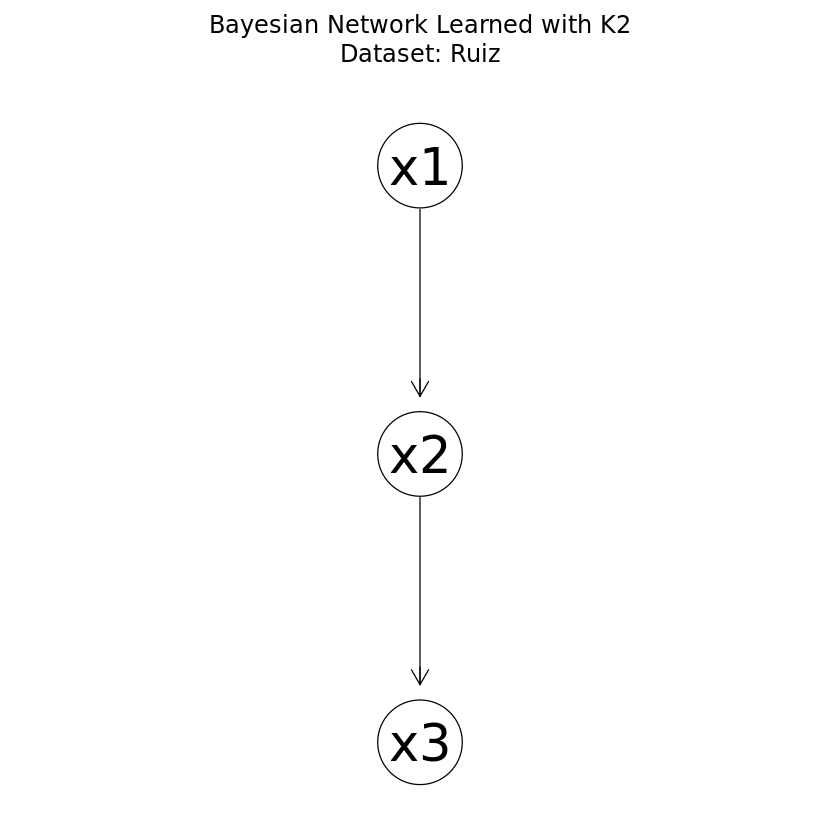

In [19]:
ruiz.result <- brute.optim(dataset("ruiz"),"Ruiz", save=FALSE, bruteforce=TRUE)

### Learning.test

##### (Bruteforce)


Execution Time: 197.336 s


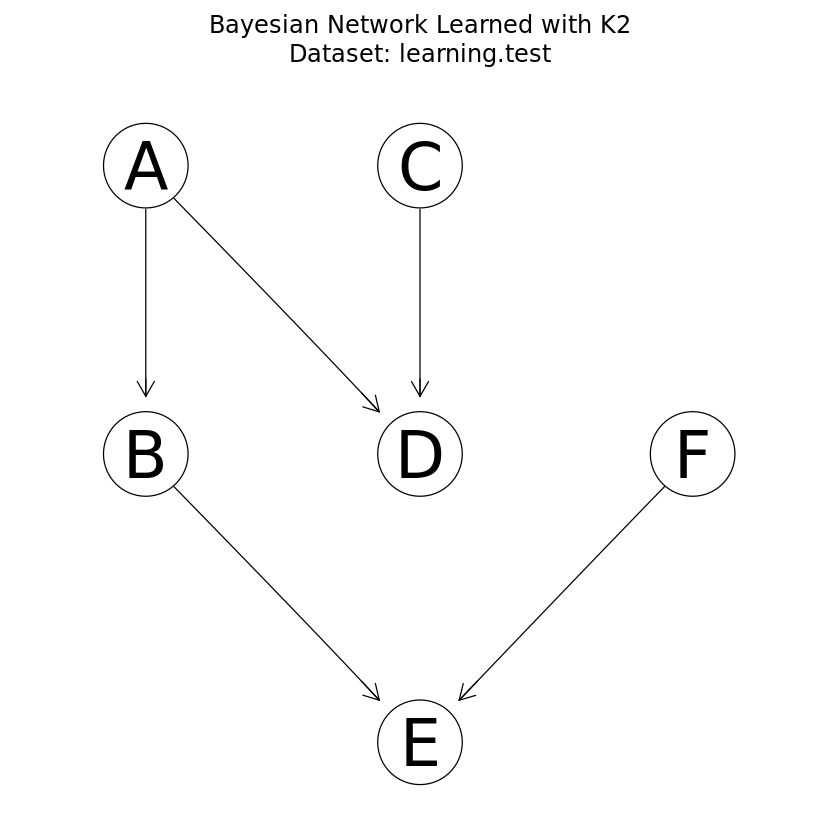

In [11]:
learning.result.b <- brute.optim(learning.test, "learning.test", save=FALSE, bruteforce=TRUE)

##### Simulated Annealing


Execution Time: 389.5913 s


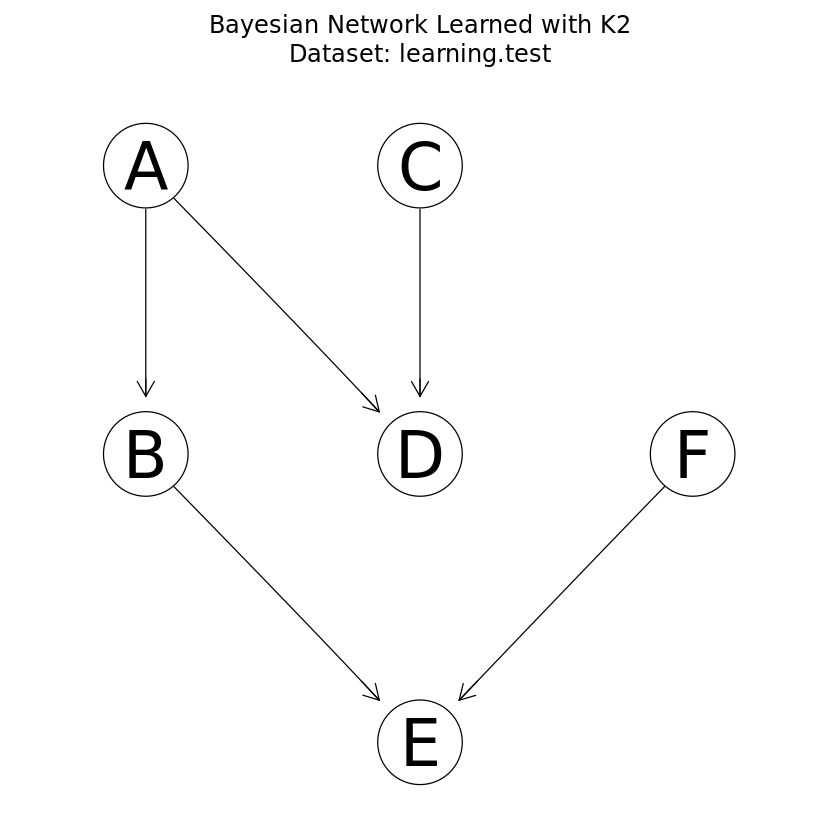

In [8]:
learning.result.sann <- brute.optim(learning.test, "learning.test",1000,10,10, save=FALSE)

### Asia

##### Bruteforce


Execution Time: 23554.39 s


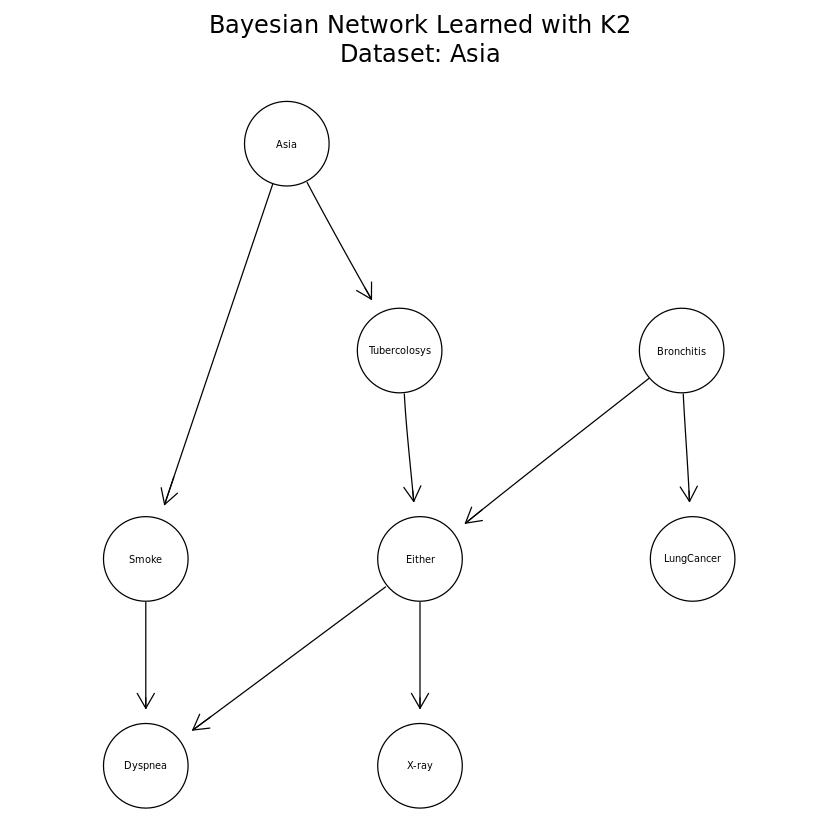

In [13]:
asia.result.b <- brute.optim(dataset(asia()), "Asia", 2500, 100 ,75, save=FALSE, bruteforce = TRUE)

##### Simulated Annealing


Execution Time: 5871.879 s


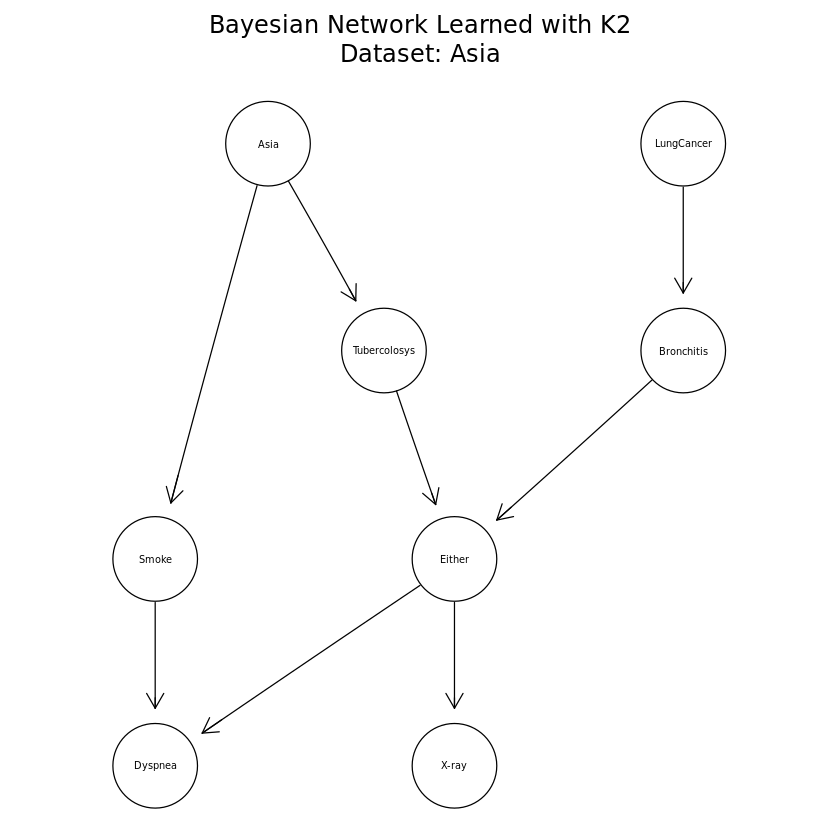

In [ ]:
asia.result.sann <- brute.optim(dataset(asia()), "Asia", 15000, 200 ,150, save=FALSE)

### Child

##### Simulated Annealing


Execution Time: 93799.24 s


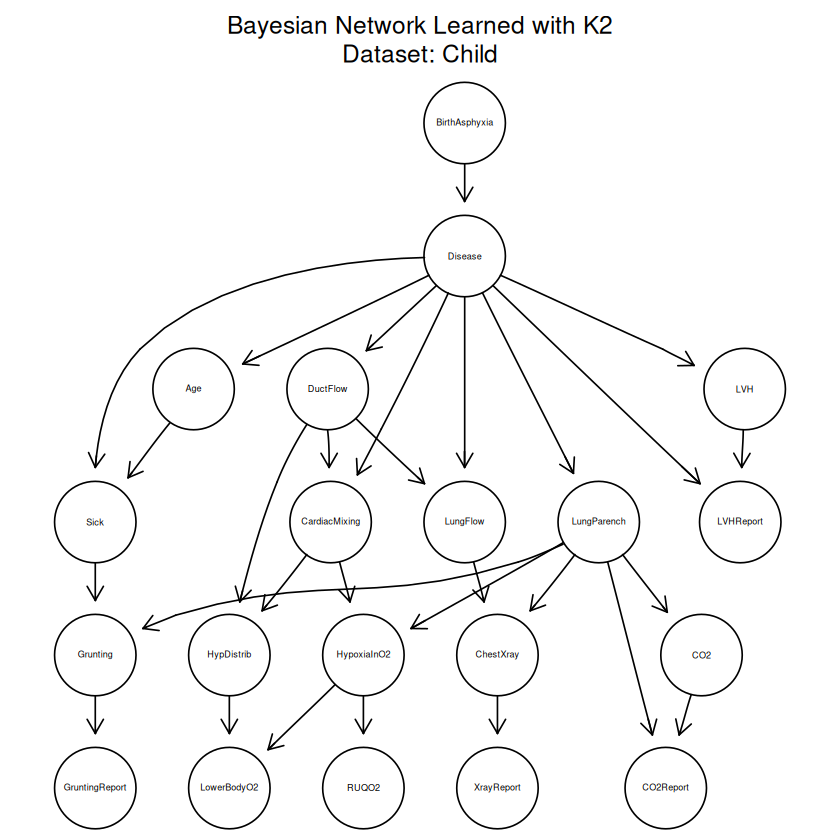

In [9]:
child.result <- brute.optim(dataset(child()), "Child", 15000, 150, 150, save =FALSE)

## Graphical Comparison

In [10]:
ruiz.paper.dag <- model2network("[x1][x2|x1][x3|x2]")
learning.library.dag <- model2network("[A][C][F][B|A][D|A:C][E|B:F]")
asia.library.dag <- model2network("[Asia][Smoke][Tubercolosys|Asia][LungCancer|Smoke][Bronchitis|Smoke][Dyspnea|Bronchitis:Either][Either|Tubercolosys:LungCancer][X-ray|Either]")
child.model.string <- paste0(
  "[BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][Age|Disease:Sick][DuctFlow|Disease]",
    "[CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease]",
    "[Grunting|Sick:LungParench][HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|CardiacMixing:LungParench][CO2|LungParench][ChestXray|LungParench:LungFlow][LVHReport|LVH]",
    "[GruntingReport|Grunting][LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]")

child.library.dag <- model2network(child.model.string)

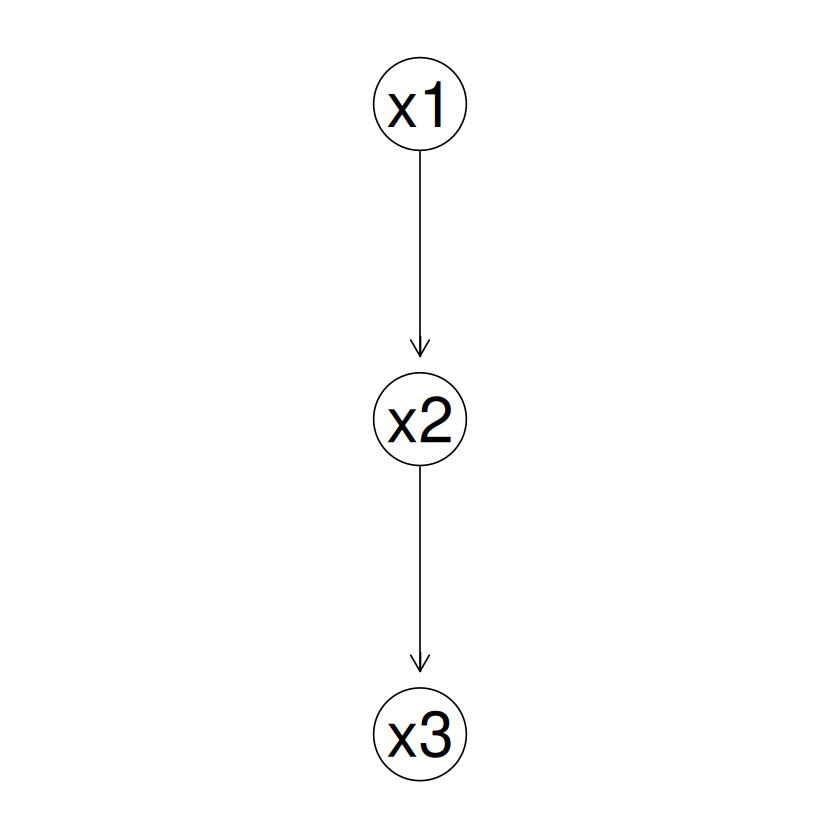

In [338]:
graphviz.compare(ruiz.paper.dag, ruiz.result$dag, shape="circle")

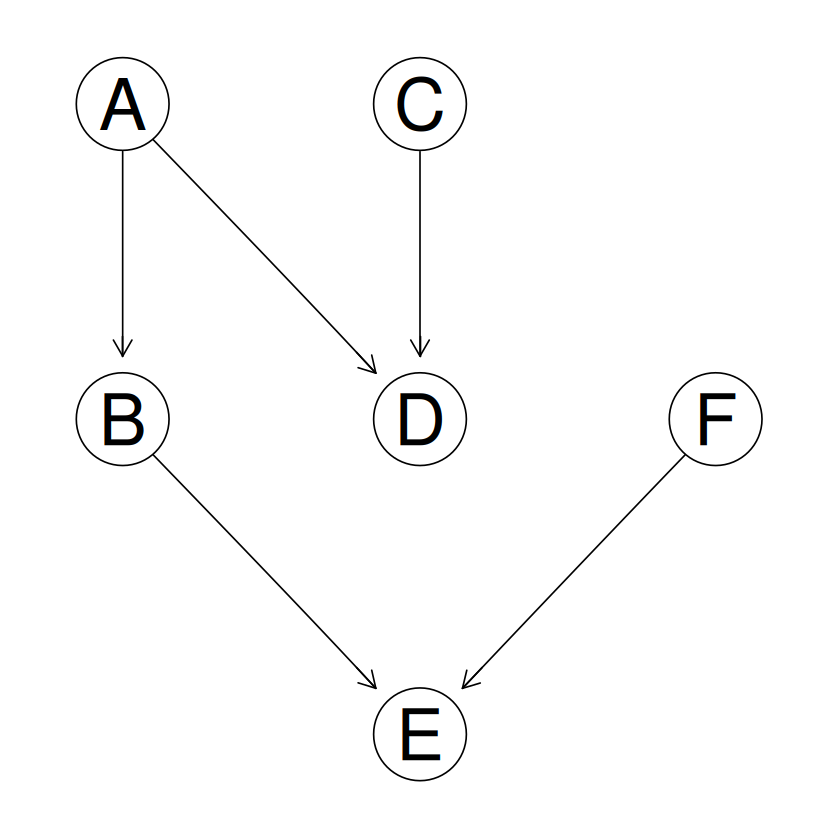

In [339]:
graphviz.compare(learning.library.dag, learning.result$dag, shape = "circle")

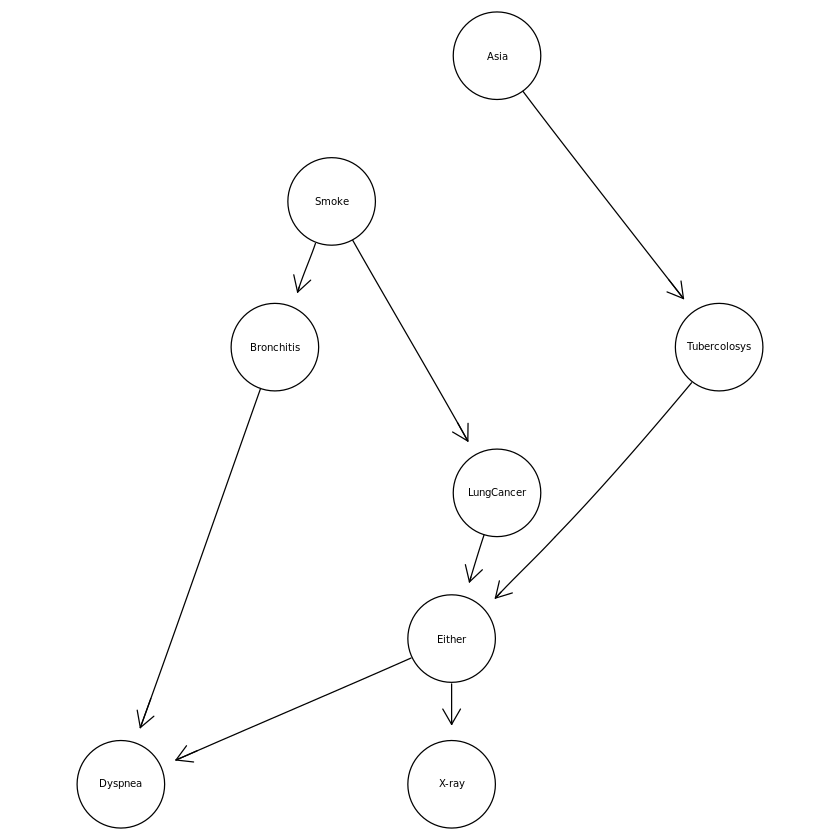

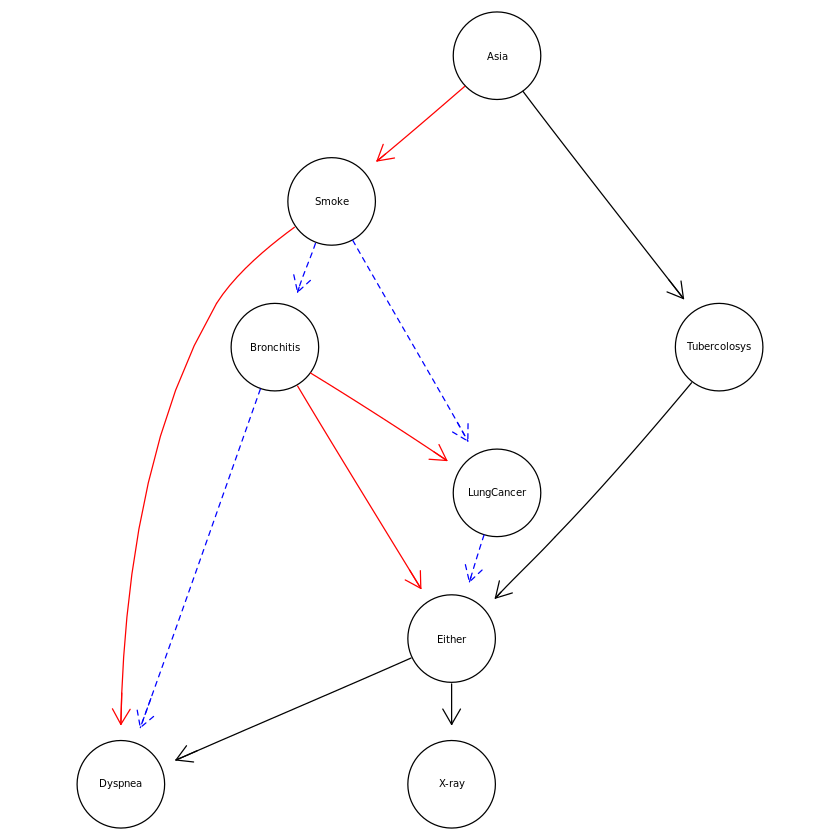

In [19]:
graphviz.compare(asia.library.dag, asia.result.b$dag, shape = "circle")

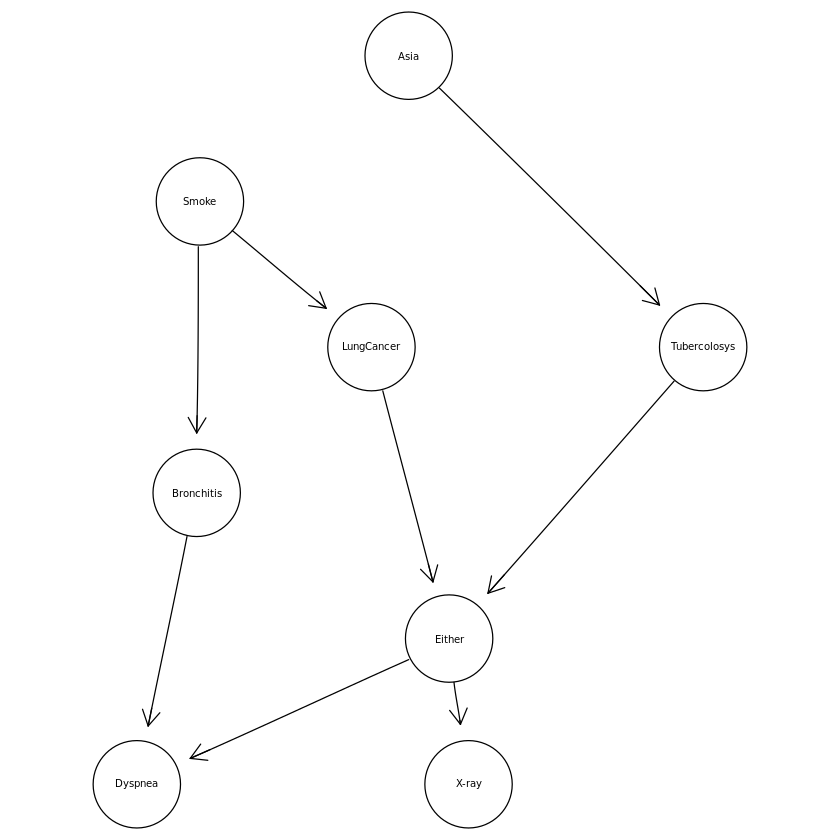

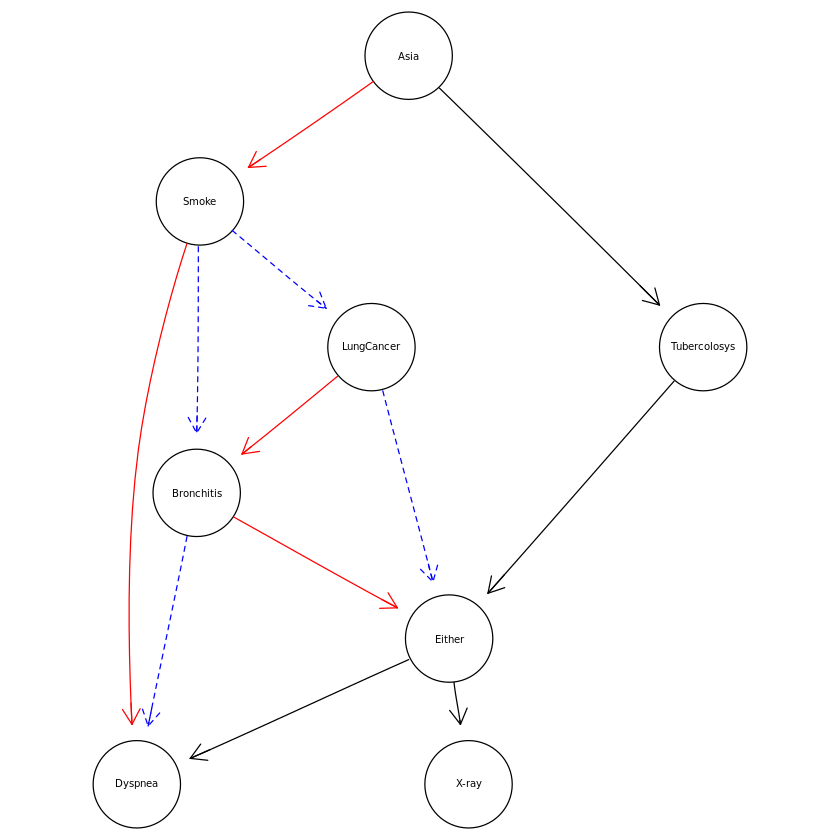

In [12]:
graphviz.compare(asia.library.dag, asia.result.sann$dag, shape = "circle")

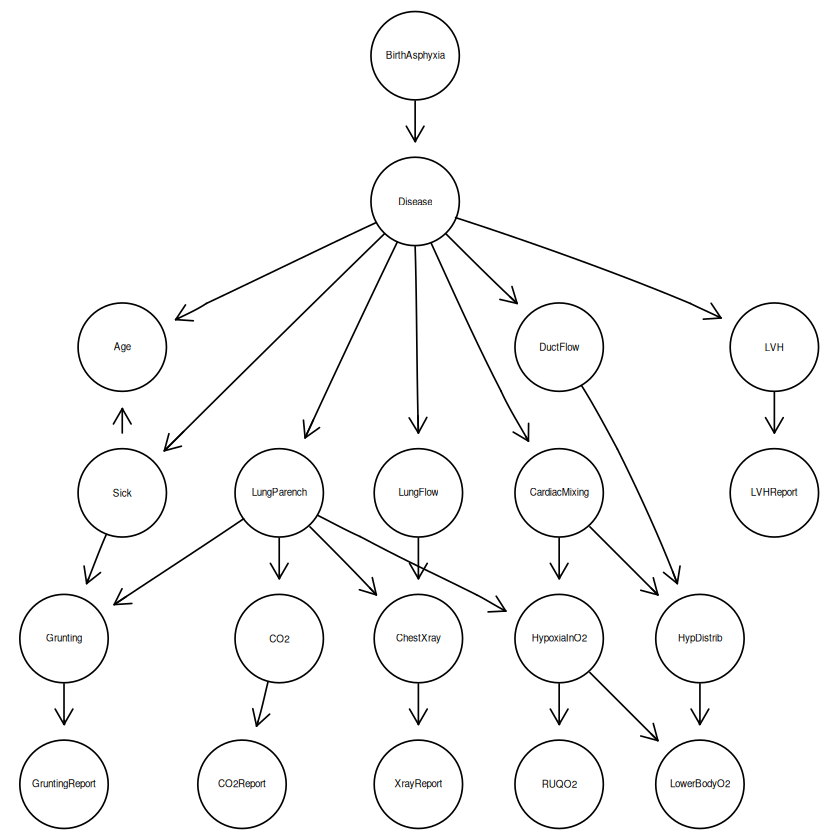

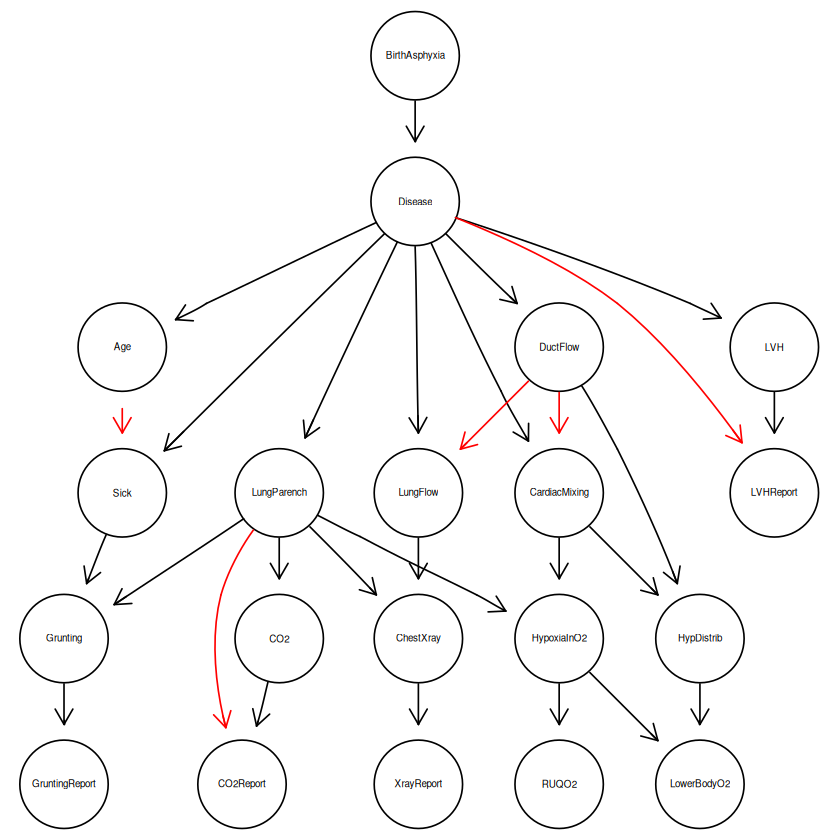

In [11]:
graphviz.compare(child.library.dag, child.result$dag, shape = "circle")

# Part 2: `bnstruct` library
Implement and test the K2 algorithm with the test data sets ([3]). Compare the results with that obtained with the bnstruct R library [4]

In this Section we show the results obtained by `MMHC` on available cases, `MMHC` on imputed data and `SEM`, with the `BDeu` and `BIC` scoring functions.

### Useful functions

In [ ]:
# from data.frame to BNDataset
df.to.BND <- function(dataframe) {
    df_name <- deparse(substitute(dataframe))  # to retrieve the name as a string
    new.BNDataset <- BNDataset(data = dataframe,
                          discreteness = rep("d", ncol(dataframe)),
                          variables = colnames(dataframe),
                          node.sizes = c(sapply(dataframe, function(col) length(unique(col)))),
                          starts.from = 0,  # otherwise it starts from 1 to |x| that here is also 1
                          bndataset.name = paste0(df_name, ".dataset"))
    return(new.BNDataset)
}                   

**PROBLEM**: `learn.network` returns an object of class **BN** which is not compatible with `graphviz.plot()` from `bnlearn` (which - again - takes in input **bn** objects), so i used `plot` instead.<br>The alternative solution is to convert from **BN** $\rightarrow$ **bn** manually extracting the adjacency matrix or arc list and rebuild the structure with `bnlearn` $\Rightarrow$ too much *sbatti*, i don't like it and for me it not worth it.

In [ ]:
learn_network <- function(dataset, impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu") {     #takes in input BNDataset
    start <- Sys.time()
    
    if (impute) {
        message("Imputing dataset")
        dataset <- impute(dataset)
    }
      
    if (impute && bootstrap) {
        message("Learning network imputing NA, then bootstrap.")
        net <- learn.network(dataset, 
                             use.imputed.data = TRUE,
                             bootstrap = TRUE, 
                             algo = algo,
                             score.fun = score.fun)
    } else if (impute) {
        message("Learning network using imputed data.")
        net <- learn.network(dataset, 
                             use.imputed.data = TRUE,
                             algo = algo,
                             score.fun = score.fun)
    } else if (bootstrap) {
        message("Learning network using bootstrap.")
        net <- learn.network(dataset, 
                             bootstrap = TRUE,
                             algo = algo,
                             score.fun = score.fun)
    } else {
        message("Learning network using default method.")
        net <- learn.network(dataset,
                             algo = algo,
                             score.fun = score.fun)
    }
    
    # grafichino
    # if we want to be sboroni we can save the fig and add it to the presentation ;)
    #pdf("learned_network_plot.pdf")
    plot(net)
    #dev.off()
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")
        
    return(net)
}

## Inspecting Dataset with `bnstruct`

### Ruiz Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |

In [ ]:
ruiz.dataset <- dataset("ruiz") |> df.to.BND()

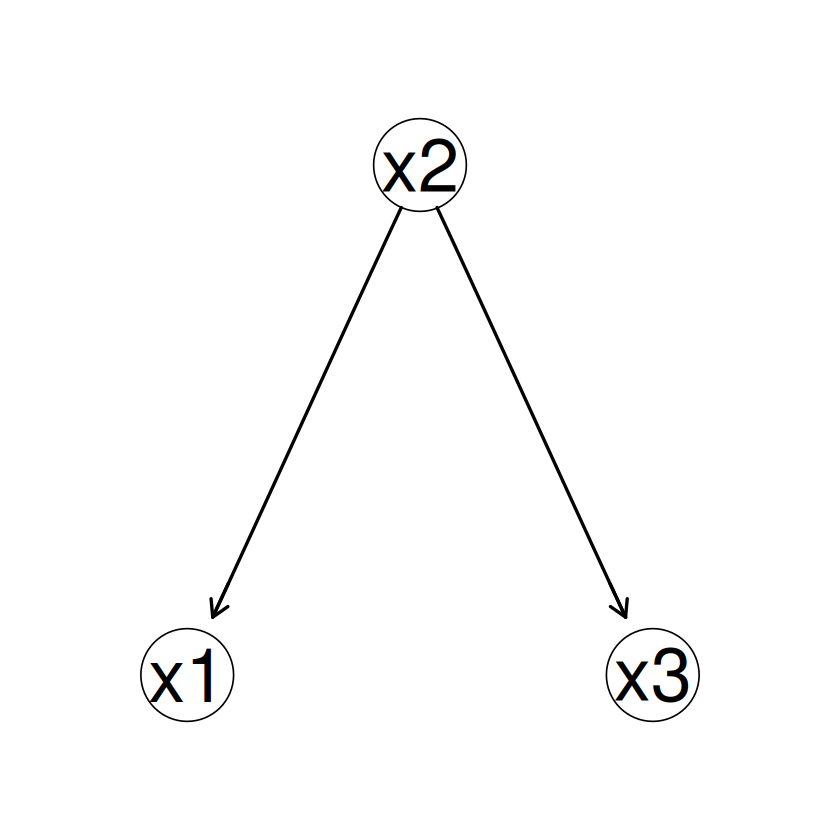

In [ ]:
ruiz.net <- learn_network(dataset = ruiz.dataset, algo="mmhc", score.fun="BDeu")

In [ ]:
ruiz.net <- learn_network(dataset = ruiz.dataset, algo="mmhc", score.fun="BIC")

### learning.test Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |

In [ ]:
learning.dataset <- data.frame(lapply(learning.test, function(col) as.integer(as.factor(col)) - 1)) |> df.to.BND()

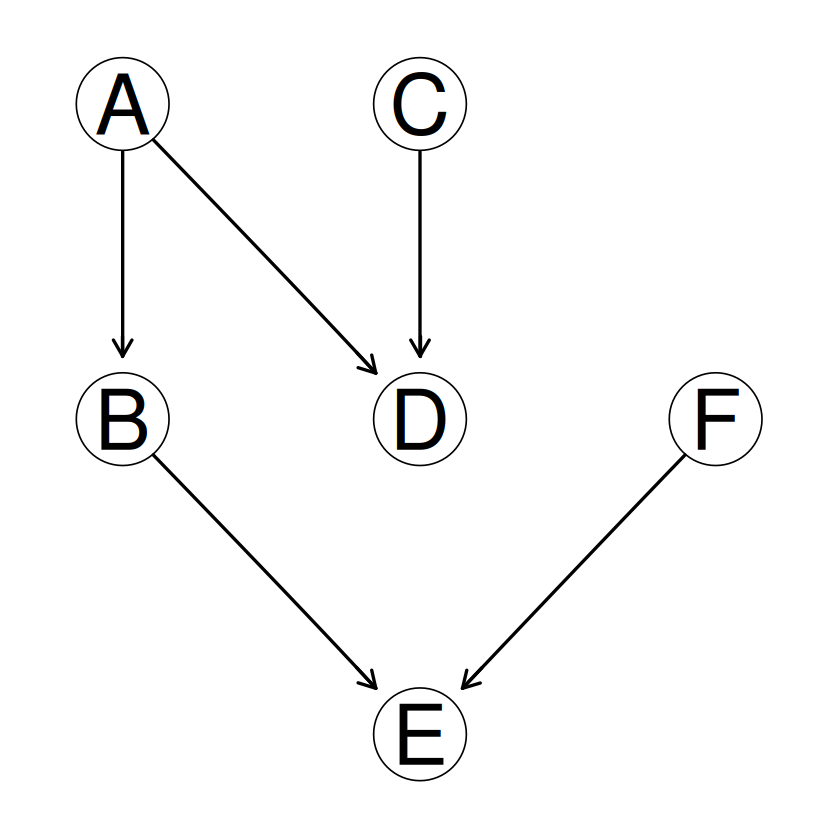

In [ ]:
learning.net <- learn_network(dataset = learning.dataset, algo="mmhc", score.fun="BDeu")

In [ ]:
learning.net <- learn_network(dataset = learning.dataset, algo="mmhc", score.fun="BIC")

### Asia Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |
| FALSE   | TRUE     | mmhc | BDeu      |
| FALSE   | TRUE     | mmhc | BIC       |


In [ ]:
asia_net <- learn_network(dataset = asia(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu")

In [ ]:
asia_net <- learn_network(dataset = asia(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BIC")

Bootstrap on Asia dataset with $bootstrap = 10000$

In [ ]:
asia_bootstrapped <- bootstrap(asia(), num.boots= 100, imputation = FALSE)

In [ ]:
asia_net <- learn_network(dataset =asia_bootstrapped , impute = FALSE, bootstrap = TRUE, algo="mmhc", score.fun="BDeu")

In [ ]:
asia_net <- learn_network(dataset =asia_bootstrapped , impute = FALSE, bootstrap = TRUE, algo="mmhc", score.fun="BIC")

### Child Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |
| FALSE  | FALSE     | sem  | BDeu      |
| (FALSE)| TRUE      | mmhc | BDeu      |
| (FALSE)| TRUE      | mmhc | BIC       |

("(FALSE)" because when bootstrapping we're imputing too with `impute = TRUE` but in the `learn_network` we set `impute = FALSE`)

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu")

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BIC")

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="sem", score.fun="BDeu")

In [ ]:
child_bootstrapped <- bootstrap(child(), num.boots= 100, imputation = TRUE)

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = TRUE, algo="mmhc", score.fun="BDeu")

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = TRUE, algo="mmhc", score.fun="BIC")